In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_base import evaluate_build, focus_build
from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_torch import torch_valid, torch_predict

In [2]:
fname               = '(F5-E32-F30)_RES(LSTM-FC-HW)x8-(FC-SELU-FC)'
evaluate_num        = 32
focus_min           = 0.3
net_block_num       = 32
hw_active           = True
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 200
batch_size_second   = 800

In [3]:
class Net_block(torch.nn.Module):
    def __init__(self, input_dims, internal_dims, output_dims, bias=True, bidirectional=True, batch_first=True, **kwargs):
        super(Net_block, self).__init__()
        self.lstm = nn.LSTM(input_dims, internal_dims, num_layers=1, bias=True, bidirectional=True, batch_first=True)
        if bidirectional:
            self.fc =nn.Linear(internal_dims*2, output_dims)
        else:
            self.fc =nn.Linear(internal_dims, output_dims)
        self._reinitialize()
        
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization/notebook
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)
    
    def forward(self, x, hw=None):
        y, _ = self.lstm(x)
        y = self.fc(y) + x
        if hw is not None:
            y = y * hw
        return y
        
class Net_test(torch.nn.Module):
    def __init__(self, evaluate_dic_list, net_block_num=net_block_num, hw_active=hw_active, **kwargs):
        super(Net_test, self).__init__()
        self.hw_layer = hw_layer(evaluate_dic_list)
        self.hw_dims = self.hw_layer.channels
        
        self.net_block_list = nn.ModuleList()
        for _ in range(net_block_num):
            self.net_block_list.append(Net_block(self.hw_dims, self.hw_dims, self.hw_dims))
        
        self.fc = nn.Sequential(nn.Linear(self.hw_dims, 32, bias=False),
                                nn.SELU(),
                                nn.Linear(32, 1, bias=True))
        self._reinitialize()
        
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization/notebook
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)
    
    def forward(self, x):
        hw = self.hw_layer(x)
        x = hw
        
        for net_block in self.net_block_list:
            x = net_block(x, hw)
        
        x = self.fc(x)
        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [6]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [7]:
print(data_train.shape)

(75450, 80, 5)


In [8]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

print(len(train_index), len(valid_index))

x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

60360 15090


In [9]:
del data_train_df
del data_test_df
gc.collect()

22

In [10]:
evaluate_list = [evaluate_build(x_test[..., i], evaluate_num) for i in range(x_test.shape[-1])]
evaluate_focus_list = []
for evaluate in evaluate_list:
    focus = 1 - (len(evaluate) - 1)/10
    if focus < focus_min:
        focus = focus_min
    evaluate_focus = focus_build(evaluate, focus)
    evaluate_focus_list.append(evaluate_focus)

evaluate_num:   3,focus:0.8000: 3it [00:00, ?it/s]
evaluate_num:   3,focus:0.8000: 3it [00:00, ?it/s]
evaluate_num:  32,focus:0.3000: 32it [00:00, 1601.89it/s]
evaluate_num:  25,focus:0.3000: 25it [00:00, 1667.64it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]


In [11]:
model = Net_test(evaluate_focus_list)
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

Net_test(
  (hw_layer): hw_layer(
    (evaluate_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(32, 1)
      (3): Embedding(25, 1)
      (4): Embedding(2, 1)
    )
    (focus_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(32, 1)
      (3): Embedding(25, 1)
      (4): Embedding(2, 1)
    )
  )
  (net_block_list): ModuleList(
    (0): Net_block(
      (lstm): LSTM(65, 65, batch_first=True, bidirectional=True)
      (fc): Linear(in_features=130, out_features=65, bias=True)
    )
    (1): Net_block(
      (lstm): LSTM(65, 65, batch_first=True, bidirectional=True)
      (fc): Linear(in_features=130, out_features=65, bias=True)
    )
    (2): Net_block(
      (lstm): LSTM(65, 65, batch_first=True, bidirectional=True)
      (fc): Linear(in_features=130, out_features=65, bias=True)
    )
    (3): Net_block(
      (lstm): LSTM(65, 65, batch_first=True, bidirectional=True)
      (fc): Linear(in_features=

In [12]:
def train_submission(epoch_num, batch_size):
    dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size)
    learn = Learner(dataLoads, model, loss_func=L1LossFlat())
    learn.lr_find()
    learn.fit_one_cycle(epoch_num, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                     SaveModelCallback(monitor='valid_loss', fname=f'{fname}_B{batch_size}_best')])
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    state_dict = torch.load(f'models/{fname}_B{batch_size}_best.pth')
    model.load_state_dict(state_dict)

    loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size, to_device=device)
    valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size, to_device=device)

    print(loss, valid_loss)

    predict = torch_predict([model.to(device)], x_test, batch_size, to_device=device)
    predict = np.reshape(predict, (-1))

    df = pd.read_csv('Database/sample_submission.csv', index_col=0)
    df['pressure'] = predict

    df.to_csv(f'Submission/{fname}_B{batch_size}.csv')

epoch,train_loss,valid_loss,time
0,3.109976,2.984897,01:37
1,1.343605,1.309825,01:36
2,1.114005,1.095743,01:36
3,0.967204,0.931466,01:43
4,0.857702,0.830299,01:35
5,0.758196,0.761560,01:54
6,0.726507,0.735013,01:35
7,0.687022,0.676779,01:45
8,0.651798,0.656055,01:37
9,0.600430,0.613370,01:37


Better model found at epoch 0 with valid_loss value: 2.9848968982696533.
Better model found at epoch 1 with valid_loss value: 1.3098251819610596.
Better model found at epoch 2 with valid_loss value: 1.0957427024841309.
Better model found at epoch 3 with valid_loss value: 0.9314664602279663.
Better model found at epoch 4 with valid_loss value: 0.8302986025810242.
Better model found at epoch 5 with valid_loss value: 0.7615604996681213.
Better model found at epoch 6 with valid_loss value: 0.7350125908851624.
Better model found at epoch 7 with valid_loss value: 0.6767791509628296.
Better model found at epoch 8 with valid_loss value: 0.6560547351837158.
Better model found at epoch 9 with valid_loss value: 0.6133700609207153.
Better model found at epoch 10 with valid_loss value: 0.6110498905181885.
Better model found at epoch 11 with valid_loss value: 0.5535998344421387.
Better model found at epoch 13 with valid_loss value: 0.5132386684417725.
Epoch 15: reducing lr to 0.0001448567362575281
B

prodict: 100% 503/503 [00:24<00:00, 20.64it/s]
C:\users\ffly\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


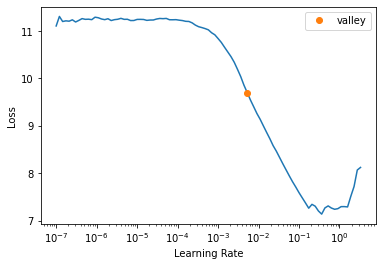

In [13]:
train_submission(epoch_num_first, batch_size_first)

epoch,train_loss,valid_loss,time
0,0.179366,0.253187,00:40
1,0.179223,0.253224,00:40
2,0.179040,0.253205,00:40
3,0.178898,0.253308,00:40
4,0.179203,0.253297,00:40
5,0.178966,0.253301,00:40
6,0.178776,0.253425,00:40
7,0.178915,0.253630,00:40
8,0.179054,0.253918,00:40
9,0.179514,0.253909,00:40


Better model found at epoch 0 with valid_loss value: 0.2531869113445282.
Epoch 10: reducing lr to 2.99801642559225e-05
Epoch 20: reducing lr to 8.004890305450764e-05
Epoch 30: reducing lr to 0.00013926615412367807
Epoch 40: reducing lr to 0.0001850129258187834
Epoch 50: reducing lr to 0.00019997864179833354
Epoch 60: reducing lr to 0.00019736420628453443
Epoch 70: reducing lr to 0.00019049452886110184
Epoch 80: reducing lr to 0.0001796698577201928
Better model found at epoch 85 with valid_loss value: 0.25023508071899414.
Epoch 90: reducing lr to 0.00016536326808994537
Better model found at epoch 93 with valid_loss value: 0.24922208487987518.
Better model found at epoch 99 with valid_loss value: 0.24863006174564362.
Epoch 100: reducing lr to 0.0001482000368697763
Better model found at epoch 101 with valid_loss value: 0.24776387214660645.
Better model found at epoch 107 with valid_loss value: 0.2472122609615326.
Epoch 110: reducing lr to 0.00012893027670395768
Better model found at epoch

prodict: 100% 63/63 [00:09<00:00,  6.60it/s]


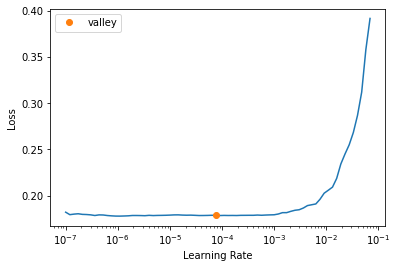

In [14]:
0train_submission(epoch_num_second, batch_size_second)